# Predicting Housing Prices in Melbourne, Australia

Author: Matthew Huh

So what factors go into determining housing prices, anyways? Some obvious factors might be the dimensions of the property, the year it was built, and the location. There are a lot factors and some of them weigh more heavily into that matter than others. To further explore this question, and predict what house prices will be based on factors like these, we'll be using a dataset for Melbourne, Australia to construct a predictive model and see how accuractely we can get to the actual housing prices.

## About the Data

There are a lot of columns in this dataset, but we won't be utilizing all of them, as they shouldn't have any effect on the outcome, or will be redundant, like latitude/ longitude compared to neighborhood. They are all listed below, if you would like to look.

1. Suburb
2. Address
3. /# of rooms
4. Type 
5. Price (the target variable)
6. Method sold
7. Seller's name
8. Date sold
9. Postcode
10. Region name
11. Property count
12. Distance
13. Council area

## Research Question

What we want to do with the data here is to see if we can predict the average price of a house by using all of the other factors at our disposal.

## Packages

In [1]:
# Basic import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Plotly packages
import plotly as py
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

# Machine learning packages
from sklearn import feature_selection as fs, linear_model
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import Imputer

## Data Preview

In [2]:
# Grab and process the raw data.
melbourne = pd.read_csv('data\\Melbourne_housing_FULL.csv')

In [3]:
# Preview our dataset
melbourne.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [4]:
# View the size of our original dataframe
melbourne.shape

(34857, 21)

In [5]:
# View null counters for each column
melbourne.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

Unfortunately, it seems as though there are a lot of null values in our dataset. Our goal is to be able to predict the price of a house based on our other factors, but if we don't have the price, we can't really predict it, now can we? 

So, rather than getting rid of all null values (21115/34857 entries), let's remove all rows where only the price is missing, and any columns missing  3 entries. This still leaves us with quite a few features to work with.

In [6]:
# Drop Latitude and longitude (we'll use regionname as the only locational feature)
melbourne.drop(['Lattitude', 'Longtitude'], axis=1, inplace=True)

# Drop all null values from 'price'
melbourne.dropna(subset=['Price'], inplace=True)

# Drop columns with too many null values
null_count = melbourne.isnull().sum() / len(melbourne)
missing_features = null_count[null_count >0.1].index
melbourne.drop(missing_features, axis=1, inplace=True)
melbourne.dropna(inplace=True)

# Viewing the size of our dataframe after dropping nulls
melbourne.shape

(27244, 13)

In [7]:
# Print out the number of unique columns in our categorical variables
categorical = melbourne.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print('{}: {}'.format(i, column.nunique()))
    
    # Drop if there are too many categories (10+)
    if column.nunique()>10:
        melbourne.drop([i], inplace=True, axis=1)

Suburb: 344
Address: 26748
Type: 3
Method: 5
SellerG: 349
Date: 78
CouncilArea: 33
Regionname: 8


We have quite a few categorical columns, but some of them contain too many unique values that will most likely slow down our model, and reduce its predictive accuracy. In order to create a cutoff point for excess features, we will be dropping every column with over 10 unique values.

In [8]:
# Examining the data
melbourne.describe()

,Rooms,Price,Distance,Postcode,Propertycount
count,27244.000000,2.724400e+04,27244.000000,27244.000000,27244.000000
mean,2.992365,1.050210e+06,11.280634,3113.799479,7566.781089
std,0.954810,6.414923e+05,6.787580,111.141993,4492.382418
min,1.000000,8.500000e+04,0.000000,3000.000000,83.000000
25%,2.000000,6.350000e+05,6.400000,3046.000000,4294.000000
50%,3.000000,8.700000e+05,10.500000,3088.000000,6567.000000
75%,4.000000,1.295000e+06,14.000000,3153.000000,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,21650.000000


In [9]:
# Setting up a dataframe for our predictors
X = pd.get_dummies(melbourne)

# Create a series with the variable we want to predict, price
y = melbourne['Price']

In [10]:
# Preview the data after data cleaning, and creating dummy variables
X.head()

,Rooms,Price,Distance,Postcode,Propertycount,Type_h,Type_t,Type_u,Method_PI,Method_S,...,Method_SP,Method_VB,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
1,2,1480000.0,2.5,3067.0,4019.0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,2,1035000.0,2.5,3067.0,4019.0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,3,1465000.0,2.5,3067.0,4019.0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
5,3,850000.0,2.5,3067.0,4019.0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
6,4,1600000.0,2.5,3067.0,4019.0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [11]:
# Show distribution of actual housing prices
data = [go.Histogram(x=y)]
layout = go.Layout(
    title = 'Actual Housing Price Distribution',
    xaxis = dict(title='Cost (in millions of AUD)', range=[0,4000000]),
    yaxis = dict(title='Count')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename = 'cufflinks/simple')

In [12]:
# View statistics on housing prices
y.describe().apply(lambda x: format(x, ',.0f'))

count        27,244
mean      1,050,210
std         641,492
min          85,000
25%         635,000
50%         870,000
75%       1,295,000
max      11,200,000
Name: Price, dtype: object

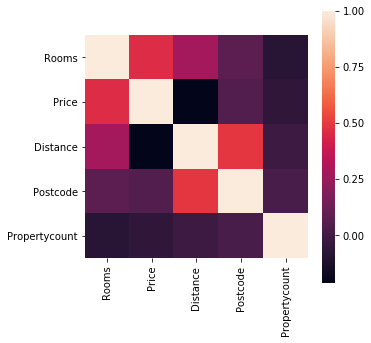

In [13]:
# Creates a correlation matrix among the predictor variables
plt.rcParams['figure.figsize'] = [5,5]

correlation_martix = melbourne.corr()
sns.heatmap(correlation_martix, vmax = 1, square = True)
plt.show()

In [14]:
# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Multivariable regression model



In [15]:
# Constructing a simple linear model
regr = LogisticRegression(random_state=0)
regr.fit(X_train, y_train)

# Inspect the results.
cross_val_score(regr, X_test, y_test, cv=5)

array([0.01662357, 0.02133633, 0.02883263, 0.02997502, 0.03198495])

In [16]:
y_pred = regr.predict(X_test)

# Show distribution of actual housing prices
data = [go.Histogram(x=y_pred)]
layout = go.Layout(
    title = 'Predicted Housing Price Distribution',
    xaxis = dict(title='Cost (in millions of AUD)', range=[0,4000000]),
    yaxis = dict(title='Count')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename = 'cufflinks/simple')

# Fine tuning the model

In [17]:
kbest = SelectKBest(f_classif, k=10)
X_train = kbest.fit_transform(X_train, y_train)

In [18]:
# Constructing a simple linear model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
print(cross_val_score(regr, X_test, y_test, cv=5))

[1. 1. 1. 1. 1.]


In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=10)
X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                          'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 
                          'principal component 9', 'principal component 10'])

X = principalDf

In [20]:
# Create training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

# Constructing a simple linear model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
print(cross_val_score(regr, X_test, y_test, cv=5))

[0.76771166 0.76894842 0.76019818 0.75116369 0.77113227]


# Source

Melbourne Housing Market
https://www.kaggle.com/anthonypino/melbourne-housing-market/version/22